In [1]:
import sys; sys.path.insert(0, '..')

import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from database.dataset import *
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from feature_extraction.feature_extraction import CandidatesFeatureExtraction
import feature_extraction.haar_features.haar_modules as hm
from general_utils.plots import plot_froc, plot_bootstrap_froc
from metrics.metrics import froc_curve, froc_curve_bootstrap
from mc_candidate_proposal.candidate_utils import balance_candidates
from metrics.metrics_utils import (get_froc_df_of_img, get_froc_df_of_many_imgs_features,
                                   get_tp_fp_fn_center_patch_criteria)

pd.options.mode.chained_assignment = None
cmap = plt.get_cmap("tab10")

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['train', 'validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=True,
    ignore_diameter_px = 15
)

# Settings

In [3]:
PATCH_SIZE = 14

hd = HoughCalcificationDetection()

# Feature extractor
haar_params = {
    'skimage': {
        'feature_type': [], 'feature_coord': []
    },
    'ours': {
        'horizontal_feature_types': [(hm.Feature3h3v, 3, 3)],
        'rotated_feature_types': [],
        'horizontal_feature_selection': None,
        'rotated_feature_selection': None,
    },
    'patch_size': 14
}

cfe = CandidatesFeatureExtraction(patch_size=PATCH_SIZE, fos=False, haar_params=haar_params)

# Example of how to train / validate a model with my changes
# (using feature arrays of all candidates)

Auc test: 0.7372488991817001


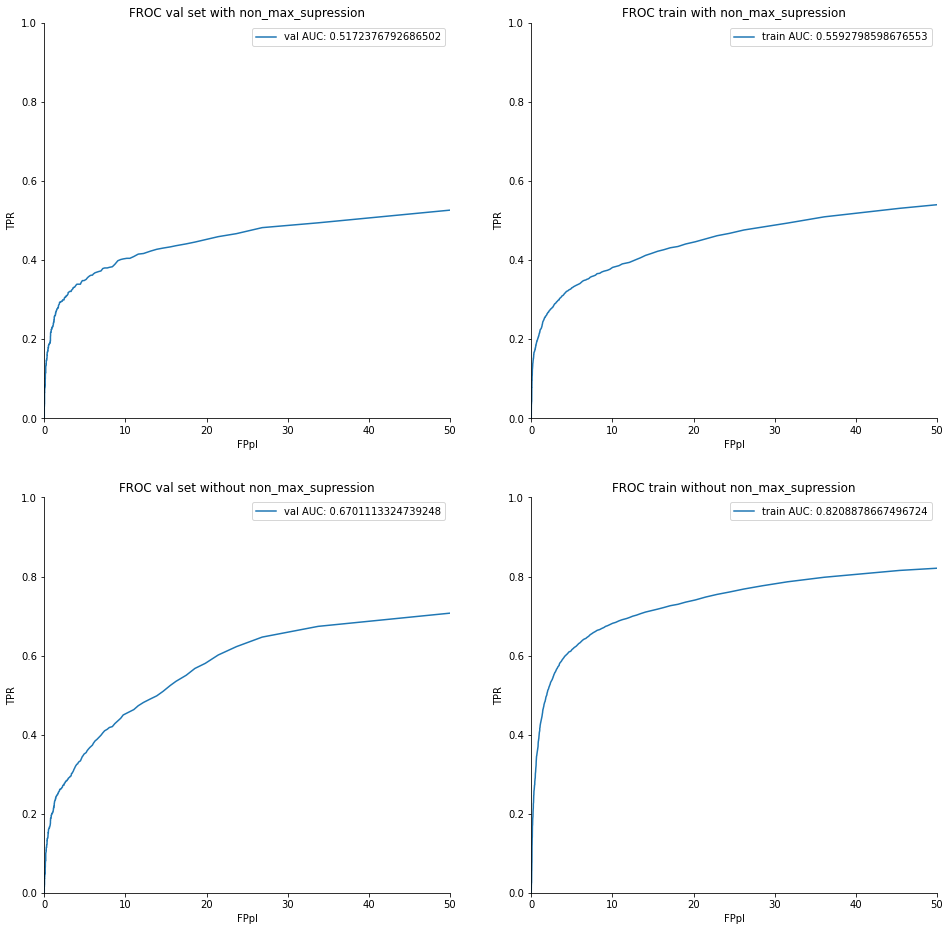

100%|██████████| 30/30 [01:00<00:00,  2.02s/it]


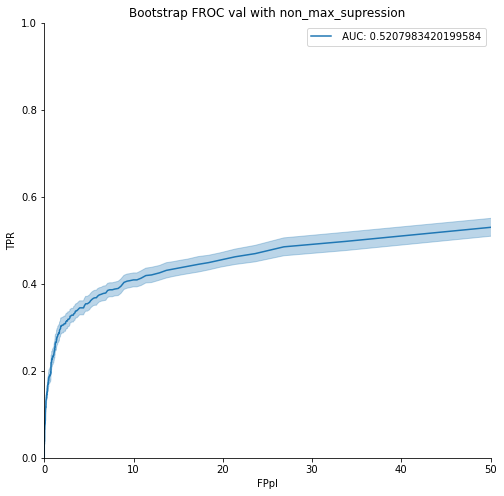

In [4]:
normal_imgs_ids = db.get_free_of_selected_lesions_imgs_ids()
test_img_id = db.df.loc[db.df.partition == 'validation', 'img_id'].unique()

data_path = Path.cwd().parent.parent/'data/temp_test_features.fth'
fn_path = Path.cwd().parent.parent/'data/temp_test_fn.fth'
if data_path.exists() and fn_path.exists:
    data = pd.read_feather(data_path)
    fns_df = pd.read_feather(fn_path)
else:
    fdf = []
    fns_df = []
    for idx in tqdm(range(len(db))):
        # Get image to process
        db_sample = db[idx]
        image = db_sample['img']
        image_id = db_sample['img_id']
        image_mask = db_sample['lesion_mask']
        muscle_mask = db_sample['muscle_mask']

        # candidate detection
        candidates = hd.detect(
            image, image_id, load_processed_images=True, hough2=False, muscle_mask=muscle_mask)[0]

        # labeling of candidates:
        tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(
            candidates, image_mask, None, 14)
        candidates = pd.concat([tp, fp], axis=0, ignore_index=True)

        # Balancing the candidates
        candidates = balance_candidates(candidates, fp2tp_sample=10)

        # Extracting features
        labels = np.where(candidates.label.values == 'TP', True, False)
        
        # Avoid extracting features for repeted detections
        X = candidates.drop_duplicates(subset='repeted_idxs')
        X = cfe.extract_features(X.loc[:, ['x','y','radius']].values.astype(int), image)

        # Get features dfs
        X = pd.DataFrame(data=X, columns=cfe.feature_names)
        X.index = candidates.drop_duplicates(subset='repeted_idxs').index

        res = X.loc[candidates.repeted_idxs.tolist(),:]
        res['img_id'] = image_id
        res['repeted_idxs'] = candidates.repeted_idxs.tolist()
        res['matching_gt'] = candidates.matching_gt.tolist()
        res['label'] = labels

        # Generate a fn dataframe to compute frocs
        fn['img_id'] = image_id
        fns_df.append(fn)
        fdf.append(res)

        print(ignored_candidates)

    data = pd.concat(fdf, ignore_index=True)
    fns_df = pd.concat(fns_df, ignore_index=True)

    data.to_feather(data_path)
    fns_df.to_feather(fn_path)


# Divide train and test based on cases (cross validation image wise)
train_df = data[~data.img_id.isin(test_img_id)]
train_fns_df = fns_df[~fns_df.img_id.isin(test_img_id)]
test_df = data[data.img_id.isin(test_img_id)]
test_fns_df = fns_df[fns_df.img_id.isin(test_img_id)]

# Generate features and labels datasets
not_feat_columns = ['patch_coordinates', 'candidate_coordinates', 'label', 'img_id', 'repeted_idxs', 'matching_gt']
train_X = train_df.drop_duplicates(subset=['repeted_idxs'])
train_X = train_X.drop(columns=not_feat_columns)
train_y = (train_df.drop_duplicates(subset=['repeted_idxs']).label).astype(int)
test_X = test_df.drop(columns=not_feat_columns)
test_y = (test_df.label).astype(int)

#Train a random forest classifier
clf_path = Path.cwd().parent.parent / 'data/test_froc_clf.sav'
if clf_path.exists():
    clf = pickle.load(open(clf_path, 'rb'))
else:
    clf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
    clf.fit(train_X, train_y)

    # Store the trained models
    pickle.dump(clf, open(clf_path, 'wb'))

# Predict
test_y_predicted = clf.predict_proba(test_X)[:, 1]
train_y_predicted = clf.predict_proba(train_df.drop(columns=not_feat_columns))[:, 1]

auc_test = roc_auc_score(test_y, test_y_predicted)

print(f'Auc test: {auc_test}')

froc_df = get_froc_df_of_many_imgs_features(
    test_df[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    test_fns_df,
    test_y_predicted,
    normal_imgs_ids
)

froc_df_train = get_froc_df_of_many_imgs_features(
    train_df[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    train_fns_df,
    train_y_predicted,
    normal_imgs_ids
)

sens, avgs_fp_per_image, _ = froc_curve(froc_df, cut_on_50fpi=True)
f, ax = plt.subplots(2,2, figsize=(16,16))
plot_froc(avgs_fp_per_image, sens, label='val', title='FROC val set with non_max_supression', ax=ax[0, 0])
sens, avgs_fp_per_image, _ = froc_curve(froc_df, non_max_supression=False, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='val', title='FROC val set without non_max_supression',ax=ax[1, 0])
sens, avgs_fp_per_image, _ = froc_curve(froc_df_train, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train', title='FROC train with non_max_supression', ax=ax[0, 1])
sens, avgs_fp_per_image, _ = froc_curve(froc_df_train, non_max_supression=False, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train', title='FROC train without non_max_supression', ax=ax[1, 1])
plt.show()

avg_sensitivities, std_sensitivities, avg_avgs_fp_per_image, _, _ = froc_curve_bootstrap(froc_df, n_sets=30, non_max_supression=True)
plot_bootstrap_froc(avg_avgs_fp_per_image, avg_sensitivities, std_sensitivities, title='Bootstrap FROC val with non_max_supression')

# Example of how to test image by image a model with my changes

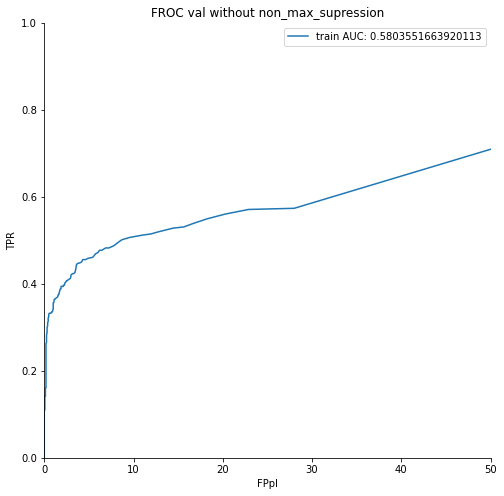

100%|██████████| 30/30 [00:25<00:00,  1.20it/s]


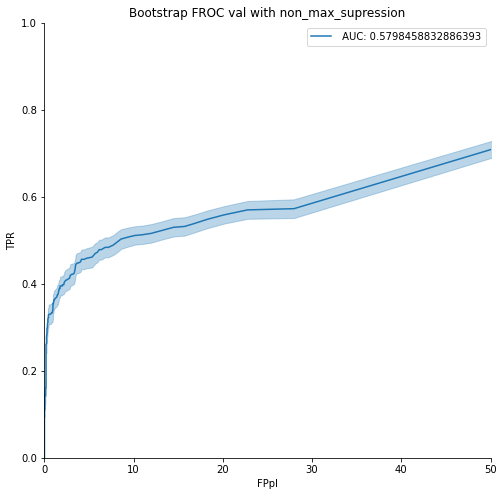

In [6]:
# Save the model to disk
normal_imgs_ids = db.get_free_of_selected_lesions_imgs_ids()
test_img_id = db.df.loc[db.df.partition == 'validation', 'img_id'].unique()

clf_path = Path.cwd().parent.parent / 'data/test_froc_clf.sav'
assert clf_path.exists(), 'Run the previous cell'
clf = pickle.load(open(clf_path, 'rb'))

froc_dfs = []
for idx in tqdm(range(60)):
    # Get image to process
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db_sample['img_id']
    if image_id not in test_img_id:
        continue
    
    image_mask = db_sample['lesion_mask']
    muscle_mask = db_sample['muscle_mask']

    # candidate detection
    candidates = hd.detect(
        image, image_id, load_processed_images=True, hough2=False, muscle_mask=muscle_mask)[0]

    # labeling of candidates:
    tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, None, 14, use_euclidean_dist=True)
    candidates = pd.concat([tp, fp], axis=0, ignore_index=True)

    # Balancing the candidates
    candidates = balance_candidates(candidates, fp2tp_sample=10)

    # Extracting features
    labels = np.where(candidates.label.values == 'TP', True, False)

    # Avoid extracting features for repeted detections
    X = candidates.drop_duplicates(subset='repeted_idxs')
    X = cfe.extract_features(X.loc[:,['x','y','radius']].values.astype(int), image)

    # Get features dfs
    predictions = clf.predict_proba(X[:,:-2])[:, 1]
    X = pd.DataFrame(data=X, columns=cfe.feature_names)
    
    # Restore repeted detections and generate standar dataframe
    froc_df = get_froc_df_of_img(candidates, fn, predictions, image_id, (image_id in normal_imgs_ids))
    froc_dfs.append(froc_df)

froc_df = pd.concat(froc_dfs, ignore_index=True)

sens, avgs_fp_per_image, _ = froc_curve(froc_df, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train', title='FROC val without non_max_supression')

avg_sensitivities, std_sensitivities, avg_avgs_fp_per_image, _, _ = froc_curve_bootstrap(froc_df, n_sets=30, non_max_supression=True)
plot_bootstrap_froc(avg_avgs_fp_per_image, avg_sensitivities, std_sensitivities, title='Bootstrap FROC val with non_max_supression')